# Approximating Steel Cased Wells - DC

[Lindsey Heagy](http://github.com/lheagy)

SimPEG and the implementation for electrical and electromagnetic methods is described in ([Cockett et al., 2015](https://doi.org/10.1016/j.cageo.2015.09.015) and [Heagy et al., 2017](https://arxiv.org/abs/1610.00804)).

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

The model setup follows . The electrical conductivities used are:
- Casing $1\times 10^6$ S/m
- Air $3\times10^{-7}$ S/m
- Background $3\times10^{-2}$ S/m
- Inside the casing - same as background

In [2]:
# experiment = 1  # 1000 m well, break at 500m, compare with short well
# experiment = 2  # 1000 m well, 70% break at 500m, compare with short well
# experiment = 3  # 1000 m well, examine break at every 100m 
experiment = 4  # 1000 m well, vary the conductivity of the background

In [3]:
simDir = 'Flawed_DC'  # create a simulation directory where results can be saved. 

In [4]:
casing_l = 1000
sigma_back = 3e-2
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness

print(
    'The casing is {}m long, and the '
    'conductivity of the background is {} S/m'.format(
        casing_l, sigma_back
    )
)

The casing is 1000m long, and the conductivity of the background is 0.03 S/m


In [5]:
model = casingSim.model.FlawedCasingInHalfspace(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 3e-7,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[2*casing_l, np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [6]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{u'__class__': 'FlawedCasingInHalfspace',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': u'Flawed_DC',
 'filename': u'ModelParameters.json',
 'flaw_r': [0.0, 0.0],
 'flaw_theta': [0.0, 6.283185307179586],
 'flaw_z': [0.0, 0.0],
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'mur_flaw': 1.0,
 'sigma_air': 3e-07,
 'sigma_back': 0.03,
 'sigma_casing': 1000000.0,
 'sigma_flaw': 5500000.0,
 'sigma_inside': 0.03,
 'src_a': [0.045000000000000005, 3.141592653589793, -1.25],
 'src_b': [2000.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'version': u'0.0.4'}

In [7]:
copiedmodelparams = {
    key: val for key, val in model.serialize().iteritems() if key in dir(casingSim.model.CasingInHalfspace) and not key.startswith('_') 
}

In [8]:
background = casingSim.model.CasingInHalfspace(
    **copiedmodelparams
)

### Set up the models

In [9]:
model.flaw_r = np.r_[model.casing_a, model.casing_b]
model.flaw_z = np.r_[-10, 0] - 500
model.sigma_flaw = model.sigma_back

In [10]:
if experiment == 1 or experiment == 2: 
    copiedmodelparams['casing_l'] = -model.flaw_z.max()
    short_casing = casingSim.model.CasingInHalfspace(**copiedmodelparams)
    
    flawed_models = {'flawed': model, 'short': short_casing}

In [11]:
if experiment == 3: 

    flaw_h = 10
    step = 100
    examples = [step*(1+i) for i in range(int(np.floor(casing_l/step)-1))]

    flawed_models = {}

    for ex in examples:
        tmp = model.copy()
        tmp.flaw_z = np.r_[-flaw_h, 0] - ex
        flawed_models['flaw_{}'.format(ex)] = tmp

In [12]:
if experiment == 4:
    
    sigma_background = [3e-3, 3e-2, 3e-1, 3]
    
    flawed_models = {}
    baseline_models = {}
    
    for sig in sigma_background:
        tmp_flawed = model.copy()
        tmp_flawed.sigma_back = sig
        tmp_flawed.sigma_flaw = sig
        tmp_flawed.sigma_inside = sig
        
        tmp_baseline = background.copy()
        tmp_baseline.sigma_back = sig
        tmp_baseline.sigma_inside = sig
        
        flawed_models['flaw_{}'.format(sig)] = tmp_flawed
        baseline_models['baseline_{}'.format(sig)] = tmp_baseline

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [13]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 500  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 22  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


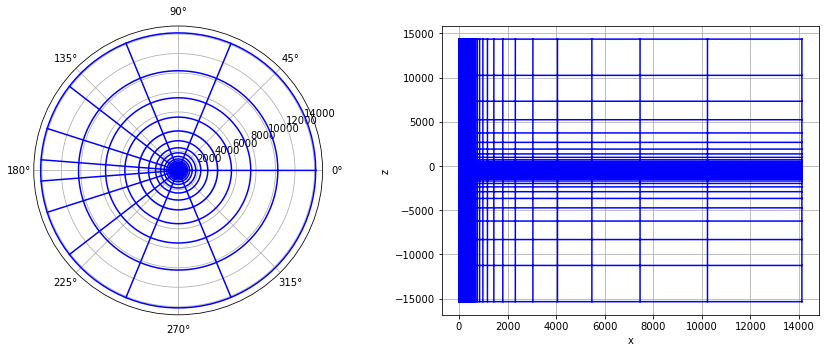

In [14]:
cylMeshGen.mesh.plotGrid()

(0.0, 3000.0)

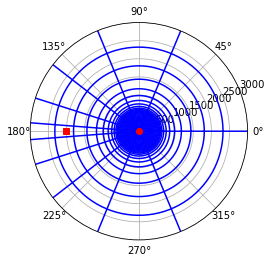

In [15]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3*model.casing_l])

In [16]:
if experiment == 2:
    flawed_models['flawed'].flaw_theta = cylMeshGen.mesh.vectorNy[[0, 9]]

In [17]:
# put the models in a dictionary for convienence 

# model_names = ['baseline', 'flawed', 'short']
# modelDict = dict(zip(model_names, [background, model, short_casing]))

if experiment != 4:
    modelDict = {'baseline': background}
    modelDict.update(flawed_models)
    model_names = ['baseline'] + sorted(flawed_models.keys())

else:
    modelDict = baseline_models
    modelDict.update(flawed_models)
    model_names = sorted(baseline_models.keys()) + sorted(flawed_models.keys())
print(model_names)

['baseline_0.003', 'baseline_0.03', 'baseline_0.3', 'baseline_3', 'flaw_0.003', 'flaw_0.03', 'flaw_0.3', 'flaw_3', 'flaw_0.003', 'flaw_0.03', 'flaw_0.3', 'flaw_3']


In [21]:
[mod.sigma_back for name, mod in modelDict.iteritems()]

[0.03, 0.3, 0.003, 3.0, 3.0, 0.03, 0.3, 0.003]

In [22]:
# Assign physical properties on the mesh
physpropsDict = dict(
    [
        (name, casingSim.model.PhysicalProperties(cylMeshGen, mod)) 
        for name, mod in modelDict.iteritems()
    ]
)

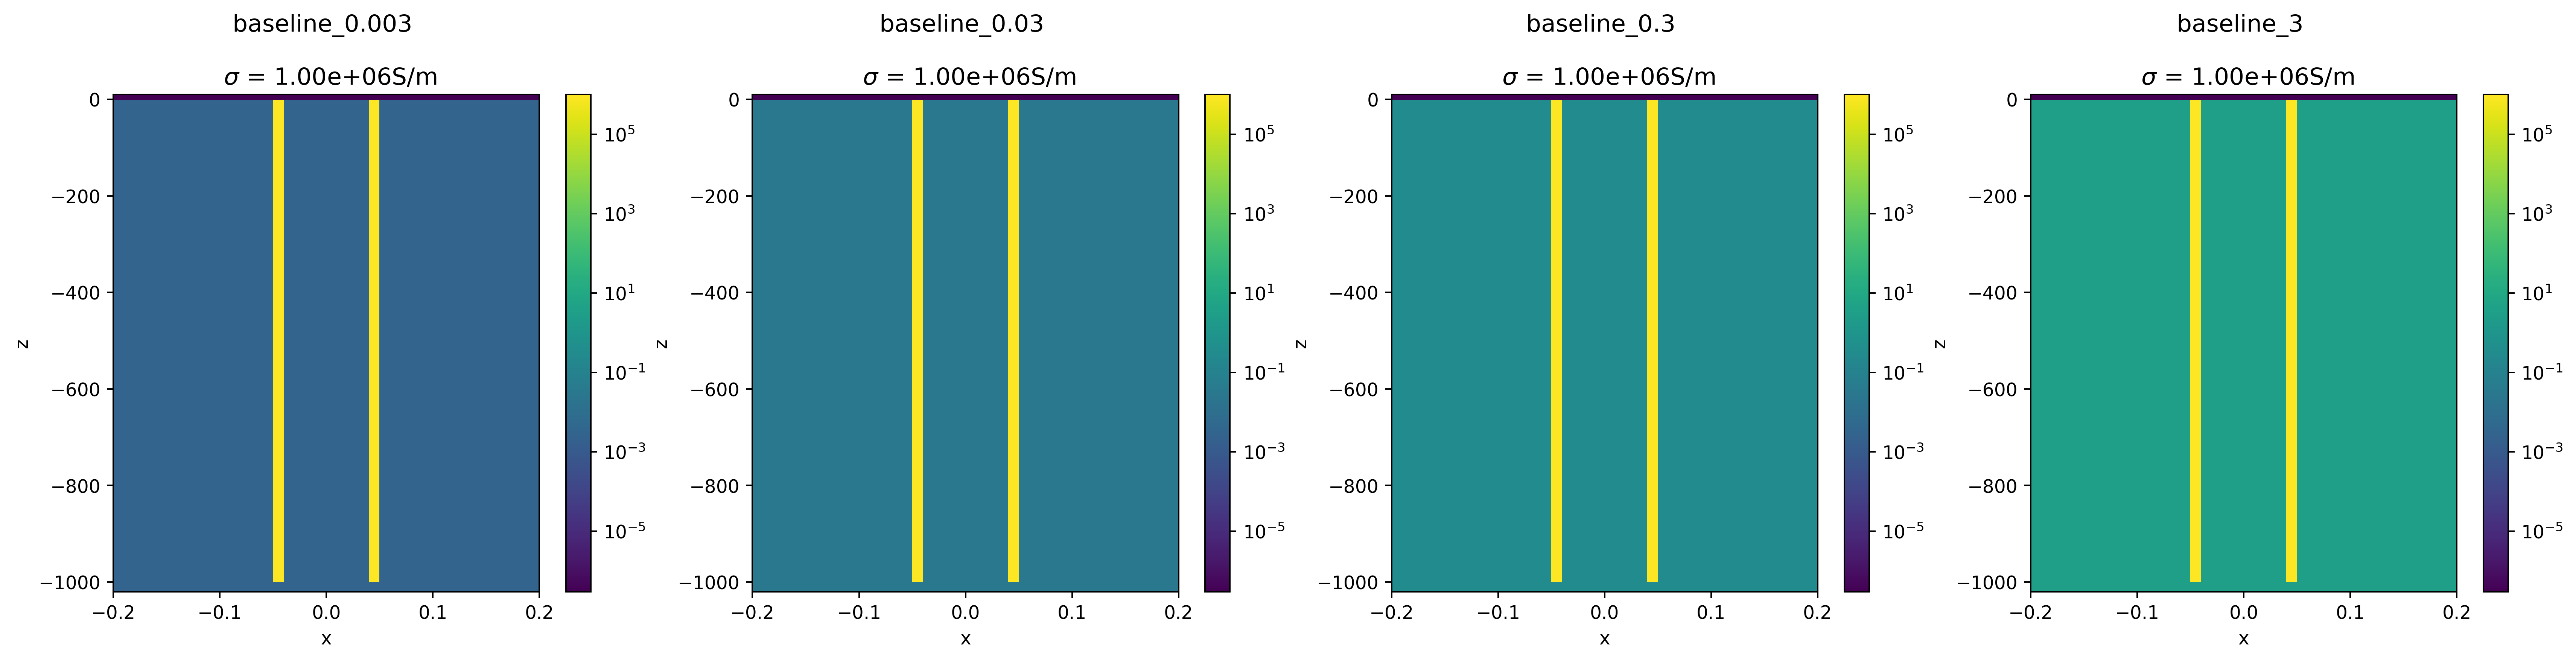

In [23]:
# Plot the models
xlim = 0.2*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-casing_l -20, 10]
    

theta_ind = 10

plot_models = model_names[:4]

fig, ax = plt.subplots(1, len(plot_models), figsize=(6*len(plot_models), 5), dpi=350)
for a, title in zip(ax, plot_models):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        theta_ind=theta_ind,
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## set up a DC simulation

In [24]:
simDict = {}
for title in model_names:
    simDict[title] = casingSim.run.SimulationDC(
        modelParameters=modelDict[title], directory=simDir, meshGenerator=cylMeshGen, src_a=model.src_a, src_b=model.src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [25]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run()
    print('\n')

--- Running baseline_0.003 ---
Validating parameters...
      max x: 14124.7083613, min z: -15352.8558054, max z: 14352.8558054, nC: 459448
Saved Flawed_DC/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 21.2234070301


--- Running baseline_0.03 ---
Validating parameters...
      max x: 14124.7083613, min z: -15352.8558054, max z: 14352.8558054, nC: 459448
Saved Flawed_DC/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 14.5920438766


--- Running baseline_0.3 ---
Validating parameters...
      max x: 14124.7083613, min z: -15352.8558054, max z: 14352.8558054, nC: 459448
Saved Flawed_DC/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 14.6364140511


--- Running baseline_3 ---
Validating parameters...
      max x: 14124.7083613, min z: -15352.8558054, max z:

## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in divide


89.8613251156


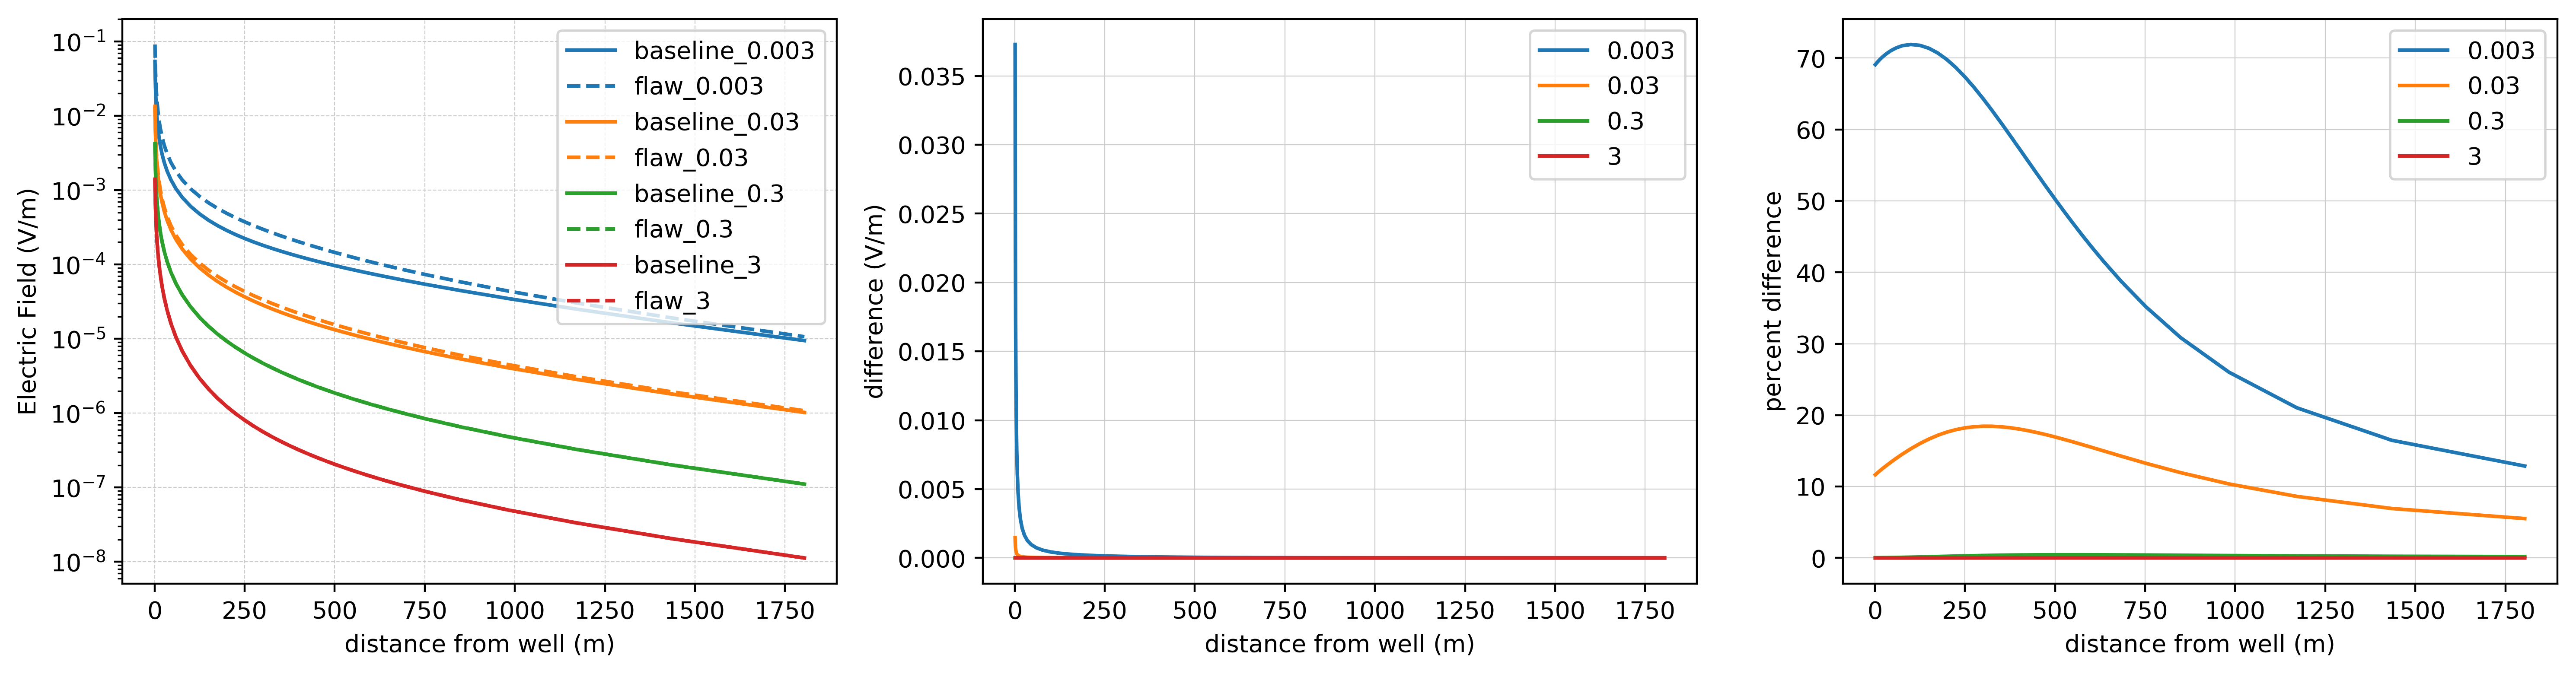

In [33]:
# plot e-field on surface

theta_ind=1 # examine data along the y-axis (90 degrees from source wire)
xlim = [1, 2000.]


if experiment != 4: 
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
    for i, key in enumerate(model_names):
        f = fieldsDict[key]
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=f[:,'e'], pltType='semilogy',
            ax=ax[0], theta_ind=theta_ind, xlim=xlim, 
            color_ind=i, label=key
        )
        if i > 0:
            f = fieldsDict[key]
            casingSim.view.plotLinesFx(
                cylMeshGen.mesh,
                field=100*(
                    np.absolute(f[:,'e'] - fieldsDict['baseline'][:,'e'])/
                    np.absolute(fieldsDict['baseline'][:,'e'])
                ),
                pltType='plot', ax=ax[1], theta_ind=theta_ind, xlim=xlim, color_ind=i,
                label=key
            )

    ax[0].set_ylabel('Electric Field (V/m)')
    ax[1].set_ylabel('percent difference')
# ax[1].set_ylim([-1, 30])
# ax[1].plot(xlim, [2, 2], '--k')

else:
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=400)
    
    for i, sig in enumerate(sigma_background):
        baseline_key = 'baseline_{}'.format(sig)
        flawed_key = 'flaw_{}'.format(sig)
        
        f_baseline = fieldsDict[baseline_key]
        f_flawed = fieldsDict[flawed_key]

        # plot data  
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=f_baseline[:,'e'], pltType='semilogy',
            ax=ax[0], theta_ind=theta_ind, xlim=xlim, 
            color_ind=i, label=baseline_key
        )
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=f_flawed[:,'e'], pltType='semilogy',
            ax=ax[0], theta_ind=theta_ind, xlim=xlim, 
            color_ind=i, label=flawed_key, linestyle='--'
        )
        
        # plot difference 
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=f_flawed[:,'e'] - f_baseline[:,'e'], pltType='plot',
            ax=ax[1], theta_ind=theta_ind, xlim=xlim, 
            color_ind=i, label=sig
        )
        
        # plot percentage
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=np.absolute(f_flawed[:,'e'] - f_baseline[:,'e'])/np.absolute(f_baseline[:,'e'])*100, pltType='plot',
            ax=ax[2], theta_ind=theta_ind, xlim=xlim, 
            color_ind=i, label=sig
        )

        ax[0].set_ylabel('Electric Field (V/m)')
        ax[1].set_ylabel('difference (V/m)')
        ax[2].set_ylabel('percent difference')
        
#         ax[1].set_ylim([-1e-4, 1e-3])
#         ax[2].set_ylim([-1, 30])

[a.legend() for a in ax]
    
plt.tight_layout()

print(cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi)

## Charges

How do the charges change with different casing models?

In [34]:
import ipywidgets

In [35]:
# Plot the charges
def plotScalar(
    theta_ind=0, clim_max=None, max_depth=1.1*model.casing_l, max_r=0.1, top=10., view='charge'
):
    fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
    
    assert view.lower() in ['charge', 'phi']

    xlim = max_r*np.r_[0, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
    }
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim
        
    for a, title in zip(ax, model_names):
        pp = physpropsDict[title]
        plotme = simDict[title].fields()[:, view]
        
        pp.plot_prop(
            plotme,
            ax=a,
            pcolorOpts = {'cmap': 'bwr' if view == 'charge' else 'viridis'},
            **plotopts
        )
        a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m, \ntheta = {:1.1f} degrees'.format(
            title, pp.modelParameters.sigma_casing, cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi
        ), fontsize=13)
    #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
        a.set_xlim(xlim)
        a.set_ylim(zlim)
        
        # plot outline of casing
        m = modelDict[title]
        a.plot(
            np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
            np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
            'k' if view == 'charge' else 'w', 
            lw = 0.5
        )
        
    plt.show()

### Widget for viewing charges

There are 3 panels, the true (left), if we were to replace the well with solid steel (center) and if we choose sigma to preserve the integrated conductance (right). For reference, I have plotted the true casing cross section.

The widgets available to you are
- **theta_ind**: [0, ntheta slices] Which azimuth should we slice through
- **clim_max**: max value on the colorbar so you can saturate it
- **max_depth**: max z-limit for the plot
- **top**: top of the plot (z)

observations:
- (sanity checks): in all charges at interface between casing and formation. All positive charges (positive electrode connected to casing
- charge distribution more uniform along length of casing for solid steel (also makes sense: better conductor)

In [57]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

ipywidgets.interact(
    plotScalar,
    theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy), value=1), 
    clim_max = ipywidgets.FloatText(value=0), 
    max_depth = ipywidgets.FloatText(value=np.ceil(1.25*model.casing_l)), 
    max_r = ipywidgets.FloatText(value=0.1),
    top = ipywidgets.FloatText(value=10),
    view = ipywidgets.ToggleButtons(
        options=['charge', 'phi'], value='charge'
    ),
)   

<function __main__.plotScalar>

In [77]:
# Plot the models

def plotScalarDifference(
    clim_max=None, theta_ind=0, max_depth=1.1*model.casing_l, max_r=0.1, top=10.,  view='charge', 
):
    assert view in ['charge', 'phi']
        
    fig, ax = plt.subplots(1, len(model_names)-1, figsize=(6*(len(model_names)-1), 5))
    
    xlim = max_r*np.r_[0, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    diff = [m for m in model_names if m != 'baseline']
    
    if len(diff) == 1:
        ax = [ax]
    
    for a, title in zip(ax, diff):
        pp = physpropsDict[title]
        plotme = simDict[title].fields()[:, view] - simDict['baseline'].fields()[:, view]
        
        if clim_max is None or clim_max == 0.:
            clim = np.absolute(plotme).max() * np.r_[-1., 1.]
        else: 
            clim = clim_max * np.r_[-1, 1]
        
        pp.plot_prop(
            plotme,
            ax=a,
            pcolorOpts={
                'cmap': 'bwr' if view == 'charge' else 'viridis',
            },
            clim=clim,
            theta_ind=theta_ind
        )
        a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m\ntheta = {:1.2f} degree'.format(
            title, pp.modelParameters.sigma_casing, cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi
        ), fontsize=13)
    #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
        a.set_xlim(xlim)
        a.set_ylim(zlim)
        
        # plot outline of casing
        m = modelDict[title]
        a.plot(
            np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
            np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
            'k' if view == 'charge' else 'w', 
            lw = 0.5
        )
    plt.show()

### Plot the difference in charge distributions (approximation - true) 

observations: 
- first: colorbar scales are different between the two! 
- solid steel: more negative at top, positive at bottom (consistent with more uniform charge distribution) 

In [78]:
ipywidgets.interact(
    plotScalarDifference,
    theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=1), 
    clim_max = ipywidgets.FloatText(value=0), 
    max_depth = ipywidgets.FloatText(value=1.25*model.casing_l), 
    max_r = ipywidgets.FloatText(value=0.1),
    top = ipywidgets.FloatText(value=10),
    view = ipywidgets.ToggleButtons(options=['charge', 'phi'], value='charge'), 
)

<function __main__.plotScalarDifference>

### Total charge on the casing

- integrate the charge on the casing. 

In [79]:
casing_charge = {}
for title in model_names:
    casing_charge[title] = (
        utils.mkvc(simDict[title].fields()[:, 'charge'])
    )[modelDict[title].ind_casing(cylMeshGen.mesh)].sum()
    print('{:8s}: {:1.8e}'.format(title, casing_charge[title]))

baseline: 4.53789384e-12
flawed  : 4.53794429e-12
short   : 4.53789714e-12


In [48]:
# Plot the models

def plotScalarDifference(
    clim_max=None, theta_ind=0, max_depth=1.1*model.casing_l, max_r=0.1, top=10.,  view='charge' 
):
    assert view in ['charge', 'phi']
        
    fig, ax = plt.subplots(1, len(flawed_models), figsize=(6*(len(flawed_models)), 5))
    
    xlim = max_r*np.r_[0, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
#     diff = [m for m in model_names if m != 'baseline']
    for i, a in enumerate(ax):
        sig = sigma_background[i]
        baseline_key = 'baseline_{}'.format(sig)
        flawed_key = 'flaw_{}'.format(sig)

        f_baseline = fieldsDict[baseline_key]
        f_flawed = fieldsDict[flawed_key]

        pp = physpropsDict[flawed_key]
        plotme = simDict[flawed_key].fields()[:, view] - simDict[baseline_key].fields()[:, view]

        if clim_max is None or clim_max == 0.:
            clim = np.absolute(plotme).max() * np.r_[-1., 1.]
        else: 
            clim = clim_max * np.r_[-1, 1]

        pp.plot_prop(
            plotme,
            ax=a,
            pcolorOpts={
                'cmap': 'bwr' if view == 'charge' else 'viridis',
            },
            clim=clim,
            theta_ind=theta_ind
        )
        a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m\ntheta = {:1.2f} degree'.format(
            flawed_key, pp.modelParameters.sigma_back, cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi
        ), fontsize=13)
    #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
        a.set_xlim(xlim)
        a.set_ylim(zlim)

        # plot outline of casing
        m = modelDict[title]
        a.plot(
            np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
            np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
            'k' if view == 'charge' else 'w', 
            lw = 0.5
        )
    plt.show()

In [49]:
ipywidgets.interact(
    plotScalarDifference,
    theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=1), 
    clim_max = ipywidgets.FloatText(value=0), 
    max_depth = ipywidgets.FloatText(value=1.25*model.casing_l), 
    max_r = ipywidgets.FloatText(value=0.1),
    top = ipywidgets.FloatText(value=10),
    view = ipywidgets.ToggleButtons(options=['charge', 'phi'], value='charge'), 
)

<function __main__.plotScalarDifference>